In [6]:
import h5py
import pickle
import folium
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F


with h5py.File('data/raw_data/PEMS-BAY/PEMS-BAY.h5', 'r') as file:

    axis0 = file['speed']['axis0'][:]               # Идентификаторы датчиков
    block0_items = file['speed']['block0_items'][:] # Идентификаторы датчиков
    axis1 = file['speed']['axis1'][:]               # Метки времени
    timestamps = pd.to_datetime(axis1)              # Преобразование меток времени в формат datetime
    speed_data = file['speed']['block0_values'][:]  # Данные замеров скорости

pems_bay = pd.DataFrame(speed_data, index=timestamps, columns=axis0)

# Открытие .pkl файла
with open('data/raw_data/PEMS-BAY/adj_PEMS-BAY.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')
    
node_ids = [x.decode('utf-8') for x in data[0]]                     # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [8]:
adj_df.to_csv('data/pems_bay_adj_df.csv')

In [9]:
pems_bay[:288].to_csv('data/pems_bay_df.csv', index_label='Time')

## model 3

### Методология

#### 1. **Преобразование Фурье**
   - **Проблема Time-Shift**: В статье утверждается, что проблема Time-Shift (сдвига во времени) затрудняет моделирование пространственной зависимости в данных о трафике. Для решения этой проблемы предлагается использовать преобразование Фурье, которое переводит данные о трафике в частотную область.
   - **Математическое обоснование**: 
     - Пусть $ f(t) $ — данные о трафике, захваченные сенсорами на определенном перекрестке. Если трафик задерживается на время $ t_0 $, то данные $ f(t-t_0) $ будут захвачены на следующем перекрестке.
     - Согласно определению преобразования Фурье:
       $$
       F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-j\omega t} dt
       $$
       $$
       F_{t_0}(\omega) = \int_{-\infty}^{\infty} f(t-t_0) e^{-j\omega t} dt
       $$
     - После преобразований доказывается, что $ F_{t_0}(\omega) = F(\omega) \cdot e^{-j\omega t_0} $, что означает, что данные в частотной области представлены в одной фазовой размерности, что упрощает изучение пространственных зависимостей между сенсорами.

#### 2. **DFDGCN (Dynamic Frequency Domain Graph Convolutional Network)**
   - **Модуль частотной области**: Основная идея DFDGCN заключается в обновлении динамической матрицы смежности $ A_D $ на основе данных о трафике, наблюдаемых в текущем окне наблюдения.
   - **Шаги модуля**:
     1. **Преобразование Фурье**: Данные о трафике $ X_t $ в каждом окне наблюдения переводятся в частотную область с помощью быстрого преобразования Фурье (FFT):
        $$
        F_t = FFT(X_t)
        $$
     2. **Встраивание идентичности и времени**: Для уменьшения влияния шума в данных о трафике вводятся встраивания идентичности сенсоров $ E_t $ и временные встраивания $ T^{W}_t $ (день недели) и $ T^{D}_t $ (час дня):
        $$
        DE_t = W_{F,t} \cdot F_t || E_t || W_{T,t} \cdot (T^{W}_t || T^{D}_t)
        $$
     3. **Одномерная свертка**: Применяется одномерная сверточная слой с ядром $ 1 \times 1 $ для дополнительного встраивания, чтобы изучить связи между измерениями $ DE_t $.
     4. **Полносвязный слой и матричное умножение**: Применяется полносвязный слой для изучения $ DE_t $, затем результат умножается на транспонированную матрицу $ DE_t $. После активационной функции и $ Softmax $ получается финальная матрица смежности:
        $$
        A^{t}_D = Softmax(ReLU(DE_t W_{adj} DE^{T}_t))
        $$
     5. **Граф сверточный слой**: Динамический частотный граф комбинируется с предопределенными графами $ P $ (из DCRNN) и самоадаптивными графами $ A_{adt} $ (из GWNet) для создания графового сверточного слоя:
        $$
        Z_t = \sum_{k=0}^{K} (P^{k} X_t W_{k,1} + A^{k}_{adt} X_t W_{k,2} + A^{t}_D X_t W_{k,3})
        $$
     6. **Обработка временной информации**: Для обработки временной информации используется классическая причинная свертка с остаточной сетью, как в GWNet.

#### 3. **Эксперименты**
   - **Датасеты**: Эксперименты проводятся на четырех реальных датасетах с десятками тысяч временных шагов и сотнями сенсоров. Статистика датасетов представлена в таблице 1.
   - **Базовые линии и метрики**: В качестве базовых линий выбраны классические методы, такие как HI, GWNet, DCRNN, AGCRN, STGCN, MTGNN, DGCRN. Метрики оценки включают среднюю абсолютную ошибку (MAE), среднеквадратичную ошибку (RMSE) и среднюю абсолютную процентную ошибку (MAPE).
   - **Настройки экспериментов**: Датасеты делятся на обучающую, валидационную и тестовую выборки в соотношении 7:1:2. Предсказываются данные о трафике на 12 временных шагов с использованием исторических данных длиной 12. Размеры встраиваний после преобразования Фурье и идентичности составляют 10, а временные встраивания $ T^{W}_t $ и $ T^{D}_t $ — 12. Размер встраивания после одномерной свертки — 30.
   - **Результаты экспериментов**: DFDGCN показывает лучшие результаты по сравнению с базовыми линиями на всех датасетах. Анализ аблационных экспериментов подтверждает эффективность частотного графа в моделировании динамической пространственной зависимости.

In [152]:
# Параметры
B = 32  # Размер батча
N = 325  # Количество датчиков
L = 12  # Длина временного окна
fft_emb = 10  # Размерность эмбеддинга частотной области
identity_emb = 10  # Размерность эмбеддинга идентичности
T_D_size = 12  # Размерность эмбеддингов времени (например, день недели)
D_W_size = 12  # Размерность эмбеддингов времени (например, час дня)
hidden_emb = 30

# Создание случайных данных для history_data (размер: B, L, N, 1)
history_data = torch.randn(B, N, L, 1)

# Эмбеддинги
Ex1 = torch.randn(L//2 + 1, fft_emb)  # Эмбеддинг частотной области, размер: (L//2+1, fft_emb)
node1 = torch.randn(N, identity_emb)  # Эмбеддинг идентичности, размер: (N, identity_emb)
T_D_emb = torch.randn(B, N, T_D_size)  # Эмбеддинг дня недели, размер: (B, N, T_D_size)
D_W_emb = torch.randn(B, N, D_W_size)  # Эмбеддинг часа дня, размер: (B, N, D_W_size)
Wd = torch.randn(N, fft_emb + identity_emb + L * 2, hidden_emb)
Wxabs = torch.randn(hidden_emb, hidden_emb)

# Логгер для записи в текстовый файл
def log_tensor_size(tensor, description, log_file='tensor_sizes.txt'):
    with open(log_file, 'a', encoding='utf-8') as f:
        f.write(f"{description}: {tensor.shape}\n")

# Преобразование Фурье по оси L (по временным данным)
xn1 = torch.fft.rfft(history_data.squeeze(-1), dim=-1)  # Преобразование Фурье, размер: [B, N, L//2+1]
log_tensor_size(xn1, "После преобразования Фурье xn1")

xn1 = torch.abs(xn1)  # Абсолютное значение
log_tensor_size(xn1, "После применения abs(xn1)")

# Нормализация данных в частотной области
xn1 = F.normalize(xn1, p=2.0, dim=1)  # Нормализация по оси N
log_tensor_size(xn1, "После нормализации по оси N")

xn1 = F.normalize(xn1, p=2.0, dim=2)  # Нормализация по оси L//2+1
log_tensor_size(xn1, "После нормализации по оси L//2+1")

# Перемножение с Ex1 (embedding для частотной области)
xn1 = torch.matmul(xn1, Ex1)  # Размерность: [B, N, fft_emb]
log_tensor_size(xn1, "После перемножения с Ex1")

# Конкатенация с идентичностью и временными эмбеддингами
xn1k = torch.cat([xn1, node1.unsqueeze(0).expand(B, -1, -1)], dim=2)  # Размерность: [B, N, fft_emb + identity_emb]
log_tensor_size(xn1k, "После конкатенации с node1")

x_n1 = torch.cat([xn1k, T_D_emb, D_W_emb], dim=2)  # Размерность: [B, N, fft_emb + identity_emb + T_D_size + D_W_size]
log_tensor_size(x_n1, "После конкатенации с T_D_emb и D_W_emb")

x1 = torch.bmm(x_n1.permute(1,0,2), Wd).permute(1,0,2)
log_tensor_size(x1, "После перемножения с Wd")

# Итоговый размер после конкатенации
log_tensor_size(x1, "Размер после конкатенации всех эмбеддингов")

adp = torch.einsum('bne, ek->bnk', (x1, Wxabs))
log_tensor_size(adp, "Размер после свертки")

adj = torch.bmm(adp, x1.permute(0, 2, 1))
log_tensor_size(adj, "Размер матрицы смежности")



In [9]:
import numpy as np
import pandas as pd

adj_df_path = 'data/pems_bay_adj_df.csv'
data_df_path = 'data/pems_bay_df.csv'

pems_bay_adj = pd.read_csv(adj_df_path)
pems_bay = pd.read_csv(data_df_path)

# Convert Time column to datetime for processing
pems_bay["Time"] = pd.to_datetime(pems_bay["Time"])
pems_bay.set_index("Time", inplace=True)

# 1. Add temporal features
pems_bay["weekday"] = pems_bay.index.weekday  # Day of the week
pems_bay["time_index"] = (pems_bay.index.hour * 12) + (pems_bay.index.minute // 5)  # Time intervals in a day
pems_bay["hour_sin"] = np.sin(2 * np.pi * pems_bay.index.hour / 24)  # Cyclical hour (sin)
pems_bay["hour_cos"] = np.cos(2 * np.pi * pems_bay.index.hour / 24)  # Cyclical hour (cos)

# 2. Add statistical features based on traffic speeds (columns excluding new ones)
speed_columns = pems_bay.columns[:-4]  # Exclude newly added columns
pems_bay["speed_mean"] = pems_bay[speed_columns].mean(axis=1)  # Row-wise mean
pems_bay["speed_std"] = pems_bay[speed_columns].std(axis=1)  # Row-wise std deviation

# 3. Add rate of change (difference) of traffic speeds
pems_bay["speed_diff"] = pems_bay[speed_columns].diff().mean(axis=1)  # Row-wise average difference

# 4. Add spatially aggregated features using adjacency matrix
adj_matrix = pems_bay_adj.set_index("Unnamed: 0").values  # Convert adjacency DataFrame to numpy array
speeds = pems_bay[speed_columns].values  # Extract speed values as numpy array
spatial_avg = adj_matrix @ speeds.T / (adj_matrix.sum(axis=1)[:, None] + 1e-3)  # Weighted average using adjacency
pems_bay["spatial_speed_mean"] = spatial_avg.T.mean(axis=1)  # Average spatial influence per row


In [10]:
series_test = pems_bay['speed_std'] / pems_bay['speed_std'].max()

tensor_result = pd.DataFrame(torch.abs(torch.fft.rfft(combined_data[0, :, :-6, 0])).numpy()).mean(axis=1)
tensor_result = tensor_result / tensor_result.max()
series_test.index = tensor_result.index


ValueError: Length mismatch: Expected axis has 288 elements, new values have 12 elements

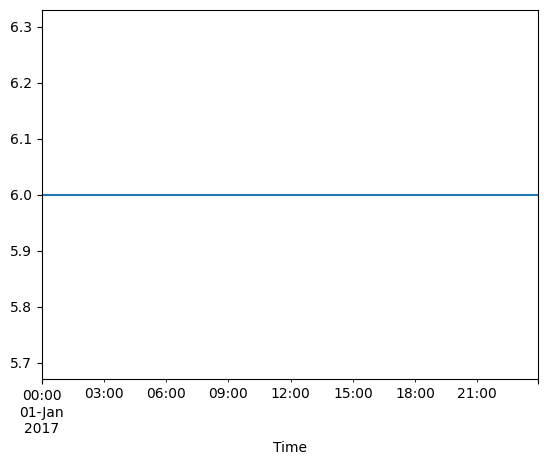

<Axes: xlabel='Time'>

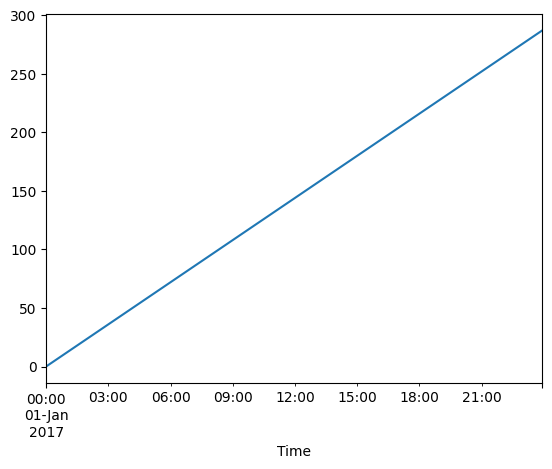

In [17]:
pems_bay['weekday'].plot()
plt.show()
pems_bay['time_index'].plot()


In [7]:
# Пример: pems_bay.index содержит DatetimeIndex
# Если pems_bay уже загружен как DataFrame:
index = pems_bay.index

# 1. Добавляем колонку для индексов дня недели (0 - понедельник, 6 - воскресенье)
pems_bay["weekday"] = index.weekday  # День недели от 0 до 6

# 2. Добавляем колонку для временного индекса в течение дня
# 288 интервалов = 24 часа * 12 (каждые 5 минут)
pems_bay["time_index"] = (index.hour * 12) + (index.minute // 5)

# 3. Преобразуем данные в тензор
# Учитываем: [B, L, N, C], где C = [трафик, день недели, временной индекс]
traffic_data = pems_bay.iloc[-12:, :-2].values  # Берем первые 12 временных шагов
weekday_data = pems_bay["weekday"].iloc[-12:].values[:, np.newaxis]  # Колонка weekday
time_index_data = pems_bay["time_index"].iloc[-12:].values[:, np.newaxis]  # Колонка time_index

# Добавляем размерность канала C к данным о трафике
traffic_data = torch.tensor(traffic_data).float().unsqueeze(-1)  # [L, N, 1]

# Добавляем размерность канала C к weekday_data и time_index_data
weekday_data = torch.tensor(weekday_data).float().unsqueeze(-1)  # [L, 1, 1]
time_index_data = torch.tensor(time_index_data).float().unsqueeze(-1)  # [L, 1, 1]

# Расширяем размерность N для weekday_data и time_index_data, чтобы они соответствовали traffic_data
weekday_data = weekday_data.expand(-1, traffic_data.size(1), -1)  # [L, N, 1]
time_index_data = time_index_data.expand(-1, traffic_data.size(1), -1)  # [L, N, 1]

# Объединяем все данные вдоль оси каналов C
combined_data = torch.cat([traffic_data, time_index_data, weekday_data], dim=-1)  # [L, N, 3]

# Добавляем размерность батча B (первая размерность)
combined_data = combined_data.unsqueeze(0)  # [1, L, N, 3]

In [ ]:
class convt(nn.Module):
    def __init__(self):
        super(convt, self).__init__()

    def forward(self, x, w):
        x = torch.einsum('bne, ek->bnk', (x, w))
        return x.contiguous()
    
class nconv(nn.Module):
    def __init__(self):
        super(nconv, self).__init__()

    def forward(self, x, A, dims):
        if dims == 2:
            x = torch.einsum('ncvl,vw->ncwl', (x, A))
        elif dims == 3:
            x = torch.einsum('ncvl,nvw->ncwl', (x, A))
        else:
            raise NotImplementedError('DFDGCN not implemented for A of dimension ' + str(dims))
        return x.contiguous()

class linear(nn.Module):
    """Linear layer."""

    def __init__(self, c_in, c_out):
        super(linear, self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(
            1, 1), padding=(0, 0), stride=(1, 1), bias=True)

    def forward(self, x):
        return self.mlp(x)

class gcn(nn.Module):
    """Graph convolution network."""

    def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
        super(gcn, self).__init__()
        self.nconv = nconv()

        self.c_in = c_in
        c_in = (order * (support_len + 1) + 1) * self.c_in
        self.mlp = linear(c_in, c_out)
        self.dropout = dropout
        self.order = order

    def forward(self, x, support):

        out = [x]
        for a in support:
            x1 = self.nconv(x, a.to(x.device), a.dim())
            out.append(x1)

            for k in range(2, self.order + 1):
                x2 = self.nconv(x1, a.to(x1.device), a.dim())
                out.append(x2)
                x1 = x2
        h = torch.cat(out, dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h

def dy_mask_graph(adj, k):
    M = []
    for i in range(adj.size(0)):
        adp = adj[i]
        mask = torch.zeros( adj.size(1),adj.size(2)).to(adj.device)
        mask = mask.fill_(float("0"))
        s1, t1 = (adp + torch.rand_like(adp) * 0.01).topk(k, 1)
        mask = mask.scatter_(1, t1, s1.fill_(1))
        M.append(mask)
    mask = torch.stack(M,dim=0)
    adj = adj * mask
    return adj

def cat(x1,x2):
    M = []
    for i in range(x1.size(0)):
        x = x1[i]
        new_x = torch.cat([x,x2],dim=1)
        M.append(new_x)
    result = torch.stack(M,dim=0)
    return result


class DFDGCN(nn.Module):

    def __init__(self, num_nodes, dropout=0.3, supports=None,
                    gcn_bool=True, addaptadj=True, aptinit=None,
                    in_dim=2, out_dim=12, residual_channels=32,
                    dilation_channels=32, skip_channels=256, end_channels=512,
                    kernel_size=2, blocks=4, layers=2, a=1, seq_len=12, affine=True, fft_emb=10, identity_emb=10, hidden_emb=30, subgraph=20):
        super(DFDGCN, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()
        self.seq_len = seq_len
        self.a = a

        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1, 1))

        self.supports = supports
        self.emb = fft_emb
        self.subgraph_size = subgraph
        self.identity_emb = identity_emb
        self.hidden_emb = hidden_emb
        self.fft_len = round(seq_len//2) + 1
        self.Ex1 = nn.Parameter(torch.randn(self.fft_len, self.emb), requires_grad=True)
        self.Wd = nn.Parameter(torch.randn(num_nodes,self.emb + self.identity_emb + self.seq_len * 2, self.hidden_emb), requires_grad=True)
        self.Wxabs = nn.Parameter(torch.randn(self.hidden_emb, self.hidden_emb), requires_grad=True)

        self.mlp = linear(residual_channels * 4,residual_channels)
        self.layersnorm = torch.nn.LayerNorm(normalized_shape=[num_nodes,self.hidden_emb], eps=1e-08,elementwise_affine=affine)
        self.convt = convt()

        self.node1 = nn.Parameter(
            torch.randn(num_nodes, self.identity_emb), requires_grad=True)
        self.drop = nn.Dropout(p=dropout)

        self.T_i_D_emb = nn.Parameter(
            torch.empty(288, self.seq_len))
        self.D_i_W_emb = nn.Parameter(
            torch.empty(7, self.seq_len))

        receptive_field = 1
        self.reset_parameter()
        self.supports_len = 0
        if not addaptadj:
            self.supports_len -= 1
        if supports is not None:
            self.supports_len += len(supports)
        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(
                    torch.randn(num_nodes, self.emb), requires_grad=True)
                self.nodevec2 = nn.Parameter(
                    torch.randn(self.emb, num_nodes), requires_grad=True)
                self.supports_len += 1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True)
                self.supports_len += 1

        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1, kernel_size), dilation=new_dilation))

                self.gate_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *= 2
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(
                        gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len))
        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.receptive_field = receptive_field

    def reset_parameter(self):
        nn.init.xavier_uniform_(self.T_i_D_emb)
        nn.init.xavier_uniform_(self.D_i_W_emb)


    def forward(self, history_data: torch.Tensor) -> torch.Tensor:
        """Feedforward function of DFDGCN; Based on Graph WaveNet

        Args:
            history_data (torch.Tensor): shape [B, L, N, C]

        Graphs:
            predefined graphs: two graphs; [2, N, N] : Pre-given graph structure, including in-degree and out-degree graphs

            self-adaptive graph: [N, N] : Self-Adaptively constructed graphs with two learnable parameters
                torch.mm(self.nodevec1, self.nodevec2)
                    nodevec: [N, Emb]

            dynamic frequency domain graph: [B, N, N] : Data-driven graphs constructed with frequency domain information from traffic data
                traffic_data : [B, N, L]
                frequency domain information : [B, N, L/2.round + 1] ------Embedding ------[B, N, Emb2]
                Identity embedding : learnable parameter [N, Emb3]
                Time embedding : Week and Day : [N, 7] [N, 24(hour) * 12 (60min / 5min due to sampling)] ------Embedding ------ [N, 2 * Emb4]
                Concat frequency domain information + Identity embedding + Time embedding ------Embedding , Activating, Normalization and Dropout
                Conv1d to get adjacency matrix

        Returns:
            torch.Tensor: [B, L, N, 1]
        """
        #num_feat = model_args["num_feat"]
        input = history_data.transpose(1, 3).contiguous()[:,0:2,:,:]
        data = history_data

        in_len = input.size(3)
        if in_len < self.receptive_field:
            x = nn.functional.pad(
                input, (self.receptive_field-in_len, 0, 0, 0))
        else:
            x = input
        x = self.start_conv(x)

        skip = 0
        if self.gcn_bool and self.addaptadj and self.supports is not None:


            gwadp = F.softmax(
                F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)

            new_supports = self.supports + [gwadp] # pretrained graph in DCRNN and self-adaptive graph in GWNet

            # Construction of dynamic frequency domain graph
            xn1 = input[:, 0, :, -self.seq_len:]

            # T_D = self.T_i_D_emb[(data[:, :, :, 1] * 288).type(torch.LongTensor)][:, -1, :, :]
            T_D = self.T_i_D_emb[(data[:, :, :, 1]).type(torch.LongTensor)][:, -1, :, :]
            D_W = self.D_i_W_emb[(data[:, :, :, 1 + 1]).type(torch.LongTensor)][:, -1, :, :]

            xn1 = torch.fft.rfft(xn1, dim=-1)
            xn1 = torch.abs(xn1)

            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=1, eps=1e-12, out=None)
            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=2, eps=1e-12, out=None) * self.a


            xn1 = torch.matmul(xn1, self.Ex1)
            xn1k = cat(xn1, self.node1)
            x_n1 = torch.cat([xn1k, T_D, D_W], dim=2)
            x1 = torch.bmm(x_n1.permute(1,0,2),self.Wd).permute(1,0,2)
            x1 = torch.relu(x1)
            x1k = self.layersnorm(x1)
            x1k = self.drop(x1k)
            adp = self.convt(x1k, self.Wxabs)
            adj = torch.bmm(adp, x1.permute(0, 2, 1))
            adp = torch.relu(adj)
            adp = dy_mask_graph(adp, self.subgraph_size)
            adp = F.softmax(adp, dim=2)
            new_supports = new_supports + [adp]

        # WaveNet layers
        for i in range(self.blocks * self.layers):

            # dilated convolution
            residual = x
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                skip = skip[:, :, :,  -s.size(3):]
            except:
                skip = 0
            skip = s + skip

            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)

                else:
                    x = self.gconv[i](x, self.supports)
            else:
                x = self.residual_convs[i](x)
            x = x + residual[:, :, :, -x.size(3):]

            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        return x
    
supports = [torch.tensor(adj_df.to_numpy(), dtype=torch.float32)]
model = DFDGCN(num_nodes=adj_df.shape[0], supports=supports)

model(combined_data).shape

torch.Size([1, 12, 325, 1])

In [ ]:
class convt(nn.Module):
    def __init__(self):
        super(convt, self).__init__()

    def forward(self, x, w):
        x = torch.einsum('bne, ek->bnk', (x, w))
        return x.contiguous()

class nconv(nn.Module):
    def __init__(self):
        super(nconv, self).__init__()

    def forward(self, x, A, dims):
        if dims == 2:
            x = torch.einsum('ncvl,vw->ncwl', (x, A))
        elif dims == 3:
            x = torch.einsum('ncvl,nvw->ncwl', (x, A))
        else:
            raise NotImplementedError('DFDGCN not implemented for A of dimension ' + str(dims))
        return x.contiguous()

class linear(nn.Module):
    """Linear layer."""

    def __init__(self, c_in, c_out):
        super(linear, self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(
            1, 1), padding=(0, 0), stride=(1, 1), bias=True)

    def forward(self, x):
        return self.mlp(x)

class gcn(nn.Module):
    """Graph convolution network."""

    def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
        super(gcn, self).__init__()
        self.nconv = nconv()

        self.c_in = c_in
        c_in = (order * (support_len + 1) + 1) * self.c_in
        self.mlp = linear(c_in, c_out)
        self.dropout = dropout
        self.order = order

    def forward(self, x, support):

        out = [x]
        for a in support:
            x1 = self.nconv(x, a.to(x.device), a.dim())
            out.append(x1)

            for k in range(2, self.order + 1):
                x2 = self.nconv(x1, a.to(x1.device), a.dim())
                out.append(x2)
                x1 = x2
        h = torch.cat(out, dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h

def dy_mask_graph(adj, k):
    M = []
    for i in range(adj.size(0)):
        adp = adj[i]
        mask = torch.zeros(adj.size(1), adj.size(2)).to(adj.device)
        mask = mask.fill_(float("0"))
        s1, t1 = (adp + torch.rand_like(adp) * 0.01).topk(k, 1)
        mask = mask.scatter_(1, t1, s1.fill_(1))
        M.append(mask)
    mask = torch.stack(M, dim=0)
    adj = adj * mask
    return adj

def cat(x1, x2):
    M = []
    for i in range(x1.size(0)):
        x = x1[i]
        new_x = torch.cat([x, x2], dim=1)
        M.append(new_x)
    result = torch.stack(M, dim=0)
    return result

class DFDGCN(nn.Module):

    def __init__(self, num_nodes, dropout=0.3, supports=None,
                    gcn_bool=True, addaptadj=True, aptinit=None,
                    in_dim=2, out_dim=12, residual_channels=32,
                    dilation_channels=32, skip_channels=256, end_channels=512,
                    kernel_size=2, blocks=4, layers=2, a=1, seq_len=12, affine=True, fft_emb=10, identity_emb=10, hidden_emb=30, subgraph=20):
        super(DFDGCN, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()
        self.seq_len = seq_len
        self.a = a

        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1, 1))

        self.supports = supports
        self.emb = fft_emb
        self.subgraph_size = subgraph
        self.identity_emb = identity_emb
        self.hidden_emb = hidden_emb
        self.fft_len = round(seq_len//2) + 1
        self.Ex1 = nn.Parameter(torch.randn(self.fft_len, self.emb), requires_grad=True)
        self.Wd = nn.Parameter(torch.randn(num_nodes, self.emb + self.identity_emb + self.seq_len * 2, self.hidden_emb), requires_grad=True)
        self.Wxabs = nn.Parameter(torch.randn(self.hidden_emb, self.hidden_emb), requires_grad=True)

        self.mlp = linear(residual_channels * 4, residual_channels)
        self.layersnorm = torch.nn.LayerNorm(normalized_shape=[num_nodes, self.hidden_emb], eps=1e-08, elementwise_affine=affine)
        self.convt = convt()

        self.node1 = nn.Parameter(
            torch.randn(num_nodes, self.identity_emb), requires_grad=True)
        self.drop = nn.Dropout(p=dropout)

        self.T_i_D_emb = nn.Parameter(
            torch.empty(288, self.seq_len))
        self.D_i_W_emb = nn.Parameter(
            torch.empty(7, self.seq_len))

        receptive_field = 1
        self.reset_parameter()
        self.supports_len = 0
        if not addaptadj:
            self.supports_len -= 1
        if supports is not None:
            self.supports_len += len(supports)
        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(
                    torch.randn(num_nodes, self.emb), requires_grad=True)
                self.nodevec2 = nn.Parameter(
                    torch.randn(self.emb, num_nodes), requires_grad=True)
                self.supports_len += 1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True)
                self.supports_len += 1

        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1, kernel_size), dilation=new_dilation))

                self.gate_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *= 2
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(
                        gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len))
        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.receptive_field = receptive_field

    def reset_parameter(self):
        nn.init.xavier_uniform_(self.T_i_D_emb)
        nn.init.xavier_uniform_(self.D_i_W_emb)

    def forward(self, history_data: torch.Tensor) -> torch.Tensor:
        """Feedforward function of DFDGCN; Based on Graph WaveNet

        Args:
            history_data (torch.Tensor): shape [B, L, N, C]

        Graphs:
            predefined graphs: two graphs; [2, N, N] : Pre-given graph structure, including in-degree and out-degree graphs

            self-adaptive graph: [N, N] : Self-Adaptively constructed graphs with two learnable parameters
                torch.mm(self.nodevec1, self.nodevec2)
                    nodevec: [N, Emb]

            dynamic frequency domain graph: [B, N, N] : Data-driven graphs constructed with frequency domain information from traffic data
                traffic_data : [B, N, L]
                frequency domain information : [B, N, L/2.round + 1] ------Embedding ------[B, N, Emb2]
                Identity embedding : learnable parameter [N, Emb3]
                Time embedding : Week and Day : [N, 7] [N, 24(hour) * 12 (60min / 5min due to sampling)] ------Embedding ------ [N, 2 * Emb4]
                Concat frequency domain information + Identity embedding + Time embedding ------Embedding , Activating, Normalization and Dropout
                Conv1d to get adjacency matrix

        Returns:
            torch.Tensor: [B, L, N, 1]
        """
        #num_feat = model_args["num_feat"]
        input = history_data.transpose(1, 3).contiguous()[:, 0:2, :, :]
        data = history_data

        in_len = input.size(3)
        if in_len < self.receptive_field:
            x = nn.functional.pad(
                input, (self.receptive_field-in_len, 0, 0, 0))
        else:
            x = input
        x = self.start_conv(x)

        skip = 0
        if self.gcn_bool and self.addaptadj and self.supports is not None:

            gwadp = F.softmax(
                F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)

            new_supports = self.supports + [gwadp] # pretrained graph in DCRNN and self-adaptive graph in GWNet

            # Construction of dynamic frequency domain graph
            xn1 = input[:, 0, :, -self.seq_len:]

            # T_D = self.T_i_D_emb[(data[:, :, :, 1] * 288).type(torch.LongTensor)][:, -1, :, :]
            T_D = self.T_i_D_emb[(data[:, :, :, 1]).type(torch.LongTensor)][:, -1, :, :]
            D_W = self.D_i_W_emb[(data[:, :, :, 1 + 1]).type(torch.LongTensor)][:, -1, :, :]

            xn1 = torch.fft.rfft(xn1, dim=-1)
            xn1 = torch.abs(xn1)

            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=1, eps=1e-12, out=None)
            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=2, eps=1e-12, out=None) * self.a

            xn1 = torch.matmul(xn1, self.Ex1)
            xn1k = cat(xn1, self.node1)
            x_n1 = torch.cat([xn1k, T_D, D_W], dim=2)
            x1 = torch.bmm(x_n1.permute(1, 0, 2), self.Wd).permute(1, 0, 2)
            x1 = torch.relu(x1)
            x1k = self.layersnorm(x1)
            x1k = self.drop(x1k)
            adp = self.convt(x1k, self.Wxabs)
            adj = torch.bmm(adp, x1.permute(0, 2, 1))
            adp = torch.relu(adj)
            adp = dy_mask_graph(adp, self.subgraph_size)
            adp = F.softmax(adp, dim=2)
            new_supports = new_supports + [adp]

        # WaveNet layers
        for i in range(self.blocks * self.layers):

            # dilated convolution
            residual = x
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                skip = skip[:, :, :,  -s.size(3):]
            except:
                skip = 0
            skip = s + skip

            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)

                else:
                    x = self.gconv[i](x, self.supports)
            else:
                x = self.residual_convs[i](x)
            x = x + residual[:, :, :, -x.size(3):]

            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        return x
